In [155]:
import pandas as pd
import numpy as np
df = pd.read_csv("fact_price_weekly_pig.csv")

In [156]:
np.random.seed(0)

In [157]:
df.head()

,id,date_sk,geo,unit,product,price,source
0,165712,20161203,GREAT BRITAIN,EUR/kg,Pig,0.17510,bordbia_pig_price
1,165711,20161203,UNITED KINGDOM,EUR/kg,Pig,0.17417,bordbia_pig_price
2,165710,20161203,NORTHERN IRELAND,EUR/kg,Pig,NaN,bordbia_pig_price
3,165709,20161203,EU,EUR/kg,Pig,0.15203,bordbia_pig_price
4,165708,20161203,UNITED STATES,EUR/kg,Pig,0.10121,bordbia_pig_price


In [158]:
df["product"] = df["product"].astype('category').cat.codes
df["unit"] = df["unit"].astype('category').cat.codes
df["source"] = df["source"].astype('category').cat.codes
df["geo"] = df["geo"].astype('category').cat.codes

In [161]:
df.head()

,id,date_sk,geo,unit,product,price,source
0,165712,20161203,8,0,0,0.17510,0
1,165711,20161203,19,0,0,0.17417,0
2,165710,20161203,14,0,0,NaN,0
3,165709,20161203,4,0,0,0.15203,0
4,165708,20161203,20,0,0,0.10121,0


In [162]:
df.price = df.price.fillna(np.mean(df.price))

In [163]:
df.price.max()

1.2395499999999999

In [164]:
from sklearn import preprocessing

min_max_scaler = preprocessing.MinMaxScaler()
df_scaled = min_max_scaler.fit_transform(df)
df_scaled = pd.DataFrame(df_scaled)
df_scaled = df_scaled.astype('float32')

In [165]:
array = np.array(df_scaled)
a,b = array.shape
array = array.reshape((1,a,b))

In [166]:
array.shape

(1, 24066, 7)

In [167]:
df_scaled.shape

(24066, 7)

In [168]:
from keras.layers import Input, Dense
from keras.models import Model

# this is the size of our encoded representations
encoding_dim = b  # 80 floats -> compression of factor 0.8, assuming the input is 100 floats

# this is our input placeholder
input = Input(shape=(a,b))
# "encoded" is the encoded representation of the input
encoded = Dense(encoding_dim, activation='relu')(input)
# "decoded" is the lossy reconstruction of the input
decoded = Dense(b, activation='sigmoid')(encoded)

# this model maps an input to its reconstruction
autoencoder = Model(inputs=input, outputs=decoded)

In [169]:
encoder = Model(inputs=input, outputs=encoded)

In [170]:

# create a placeholder for an encoded (32-dimensional) input
encoded_input = Input(shape=array.shape[1:])
# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# create the decoder model
decoder = Model(inputs=encoded_input, outputs=decoder_layer(encoded_input))

In [171]:
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')


In [172]:
# Just compute the distance before learning (show be very bad !)
import numpy as np
test_encode = encoder.predict(array)
test_decode = decoder.predict(test_encode)
test_encode = test_encode.reshape((a,b))
test_decode = test_decode.reshape((a,b))
test_array = array.reshape((a,b))
naivedist = np.zeros(len(df_scaled.values))
for i, x in enumerate(test_array):
    naivedist[i] = np.linalg.norm(x-test_decode[i]) 

In [173]:
df["naivedist"] = naivedist

In [174]:
autoencoder.fit(array, array,
                epochs=2500,
                batch_size=100,
                shuffle=True,
                verbose=0)

In [175]:
encoded = encoder.predict(array)
decoded = decoder.predict(encoded)

In [176]:
encoded = encoded.reshape((a,b))
decoded = decoded.reshape((a,b))
array = array.reshape((a,b))


In [177]:
import numpy as np

dist = np.zeros(len(df_scaled.values))
for i, x in enumerate(array):
    dist[i] = np.linalg.norm(x-decoded[i]) 

In [178]:
df["dist"] = dist

In [207]:
def mad_based_outlier(points, thresh=4):
    """
    Returns a boolean array with True if points are outliers and False 
    otherwise.

    Parameters:
    -----------
        points : An numobservations by numdimensions array of observations
        thresh : The modified z-score to use as a threshold. Observations with
            a modified z-score (based on the median absolute deviation) greater
            than this value will be classified as outliers.

    Returns:
    --------
        mask : A numobservations-length boolean array.

    References:
    ----------
        Boris Iglewicz and David Hoaglin (1993), "Volume 16: How to Detect and
        Handle Outliers", The ASQC Basic References in Quality Control:
        Statistical Techniques, Edward F. Mykytka, Ph.D8., Editor.
    """
    if len(points.shape) == 1:
        points = points[:,None]
    median = np.median(points, axis=0)
    diff = np.sum((points - median)**2, axis=-1)
    diff = np.sqrt(diff)
    med_abs_deviation = np.median(diff)

    modified_z_score = 0.6745 * diff / med_abs_deviation
    return modified_z_score > thresh

def percentile_based_outlier(data, threshold=99):
    diff = (100 - threshold) / 2.0
    minval, maxval = np.percentile(data, [diff, 100 - diff])
    return (data < minval) | (data > maxval)

results = mad_based_outlier(dist)
results_per = percentile_based_outlier(dist)

In [208]:
df["Outlier_Verdict"] = results
df["Outlier_per"] = results_per

In [181]:
df.Outlier_Verdict.unique()

array([True, False], dtype=object)

In [182]:
def anomaly_detector2(feature,Z=3):
    results = []
    diff_X = []
    X= np.sort(feature)
    for i in range(len(feature)):
        if i ==0:
            value = feature[i]
        else:
            value = feature[i] - feature[i-1]
        diff_X.append(value)
    X_mean = np.mean(diff_X)
    X_std = np.std(diff_X)
    X_upper = X_mean + X_std*Z
    X_lower = X_mean - X_std*Z
    for i in diff_X:
        if X_upper < i or X_lower > i:
            results.append(True)
        else:
            results.append(False)
    return results

In [183]:
df["Outlier_RM"] = anomaly_detector2(df["price"])

In [184]:
df.Outlier_RM.unique()

array([True, False], dtype=object)

In [202]:
df[df.Outlier_RM==True]

,id,date_sk,geo,unit,product,price,source,naivedist,dist,Outlier_Verdict,Outlier_per,Outlier_RM,Outlier
0,165712,20161203,8,0,0,0.175100,0,1.203914,0.322401,True,False,True,1
1711,14074,19960622,12,0,0,1.210780,0,1.119582,0.949007,True,True,True,1
1712,14075,19960622,13,0,0,0.166040,0,1.141691,0.058130,False,False,True,0
1926,14289,19960831,18,0,0,0.011890,0,1.234762,0.118102,False,False,True,0
1927,14290,19960831,20,0,0,0.124290,0,1.211516,0.072179,False,False,True,0
1945,14308,19960907,16,0,0,0.021500,0,1.212351,0.121925,False,False,True,0
1946,14309,19960907,17,0,0,0.188580,0,1.153515,0.057001,False,False,True,0
3463,15826,19980124,19,0,0,1.239550,0,1.119742,0.957123,True,True,True,1
3464,15827,19980124,8,0,0,0.146117,0,1.124226,0.032305,False,False,True,0
4447,16810,19981219,20,0,0,0.021020,0,1.212153,0.120921,False,False,True,0


In [203]:
j = 0
length = len(df)
for i in range(len(df)):
    idx = df.index[i]
    if df.loc[idx,"Outlier_Verdict"] == df.loc[idx,"Outlier_RM"]:
        j = j+1
float(j)/float(length)

0.9847502700905842

In [204]:
a = df[(df.Outlier_Verdict == True)]
len(a)

338

In [205]:
df["Outlier"] = df.apply(lambda x: 1 if abs(x['dist']) > 0.22 else 0, axis=1)

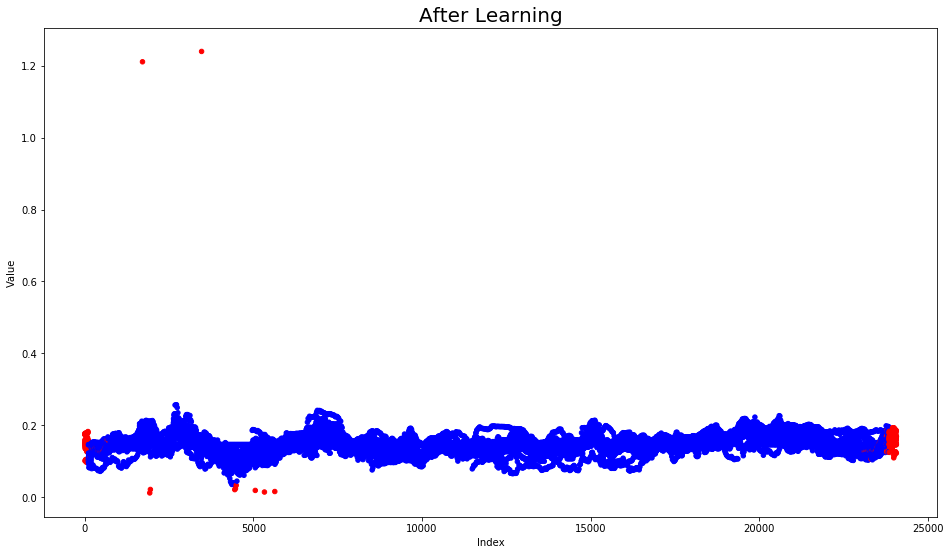

In [211]:
%matplotlib inline
import matplotlib.pyplot as plt
use_colours = {0: "blue", 1: "red"}
#ax.scatter(a,b,c,c=[use_colours[x[0]] for x in df["Outlier"]],s=50)

plt.figure(figsize=(16,9))
plt.scatter(df.index, df['price'], c=[use_colours[x] for x in df["Outlier_Verdict"]], s=20)
plt.xlabel('Index')
plt.ylabel('Value')
plt.title("After Learning", fontsize="20")


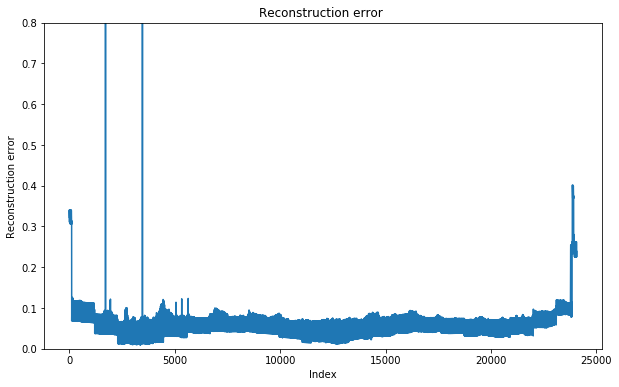

In [192]:
plt.figure(figsize=(10,6))
plt.plot(dist)
#plt.xlim((0,100))
plt.ylim((0,0.8))
plt.xlabel('Index')
plt.ylabel('Reconstruction error')
plt.title("Reconstruction error ")

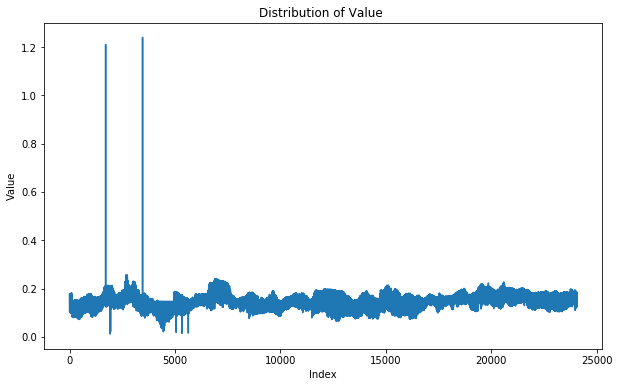

In [212]:
value = np.array(df["price"])
plt.figure(figsize=(10,6))
plt.plot(value)

#plt.xlim((0,1000))
#plt.ylim((0,0.8))
plt.xlabel('Index')
plt.ylabel('Value')
plt.title("Distribution of Value ")